<a href="https://www.kaggle.com/code/kiranpathak97/movie-recommendations?scriptVersionId=148421968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from surprise import Reader, Dataset, SVD, KNNBasic, NMF, accuracy
from surprise.model_selection import cross_validate, train_test_split

# Load Dataset
Dataset: [Download link](http://https://grouplens.org/datasets/movielens/latest/)

## Movies Dataset

In [3]:
df_movies = pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.shape

(9742, 3)

### Remove duplicates

In [5]:
df_movies['movieId'].nunique()

9742

In [6]:
df_movies['title'].nunique()

9737

In [7]:
df_movies['title'].duplicated().any()

True

In [8]:
duplicates = df_movies.duplicated(subset=['title'], keep=False)

if duplicates.any():
  print(df_movies[['title', 'genres']].loc[duplicates])

                                       title  \
650                              Emma (1996)   
2141                         Saturn 3 (1980)   
4169  Confessions of a Dangerous Mind (2002)   
5601                             Emma (1996)   
5854                             Eros (2004)   
5931                War of the Worlds (2005)   
6932                War of the Worlds (2005)   
9106  Confessions of a Dangerous Mind (2002)   
9135                             Eros (2004)   
9468                         Saturn 3 (1980)   

                                   genres  
650                  Comedy|Drama|Romance  
2141            Adventure|Sci-Fi|Thriller  
4169          Comedy|Crime|Drama|Thriller  
5601                              Romance  
5854                                Drama  
5931     Action|Adventure|Sci-Fi|Thriller  
6932                        Action|Sci-Fi  
9106  Comedy|Crime|Drama|Romance|Thriller  
9135                        Drama|Romance  
9468                      Sci-F

In [9]:
# manually remove index 5601, 9468, 4169, 5854, 6932

df_movies = df_movies.drop([5601, 9468, 4169, 5854, 6932])
df_movies.shape

# duplicates = df_movies.duplicated(subset=['title']).sum()
# print(f"Number of duplicates: {duplicates}")
# drop duplicates
#df_movies.drop_duplicates(subset=['title'], keep='first', inplace=True)

(9737, 3)

In [10]:
df_movies = df_movies.reset_index(drop=True)
df_movies.tail()

,movieId,title,genres
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9734,193585,Flint (2017),Drama
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9736,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [11]:
df_movies.columns = df_movies.columns.str.lower()
df_movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
df_movies_new = df_movies.copy()

In [13]:
df_movies['genres'] = df_movies['genres'].str.replace('|',' ')

### Extract Genres

In [14]:
df_movies_new['genreslist'] = df_movies_new['genres'].apply(lambda x:x.split('|'))

In [15]:
df_movies_new['genres'] = df_movies_new['genres'].str.replace('|',' ')

In [16]:
df_movies_new.head()

,movieid,title,genres,genreslist
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure Children Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [17]:
genres = df_movies_new['genreslist'].apply(Counter)
genres.head()

0    {'Adventure': 1, 'Animation': 1, 'Children': 1...
1        {'Adventure': 1, 'Children': 1, 'Fantasy': 1}
2                          {'Comedy': 1, 'Romance': 1}
3              {'Comedy': 1, 'Drama': 1, 'Romance': 1}
4                                        {'Comedy': 1}
Name: genreslist, dtype: object

In [18]:
genres = pd.DataFrame.from_records(genres).fillna(value=0)
genres.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_movies_new = df_movies_new.join(genres)
df_movies_new.shape

(9737, 24)

In [20]:
df_movies_new = df_movies_new.drop(['genreslist'], axis=1)

In [21]:
df_movies_new.head(3)

,movieid,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure Children Fantasy,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy Romance,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_movies_new.columns

Index(['movieid', 'title', 'genres', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'],
      dtype='object')

In [23]:
df_movies_new[['Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)']] = df_movies_new[['Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)']].apply(pd.to_numeric, downcast='integer')

df_movies_new.head(3)

,movieid,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure Children Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_movies_new.rename(columns = {'Sci-Fi':'Sci_Fi', 'Film-Noir':'Film_Noir', '(no genres listed)':'No_Genres'}, inplace=True)
df_movies_new.columns = df_movies_new.columns.str.lower()

In [25]:
df_movies_new.head(3)

,movieid,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,horror,mystery,sci_fi,war,musical,documentary,imax,western,film_noir,no_genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure Children Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Ratings Dataset

In [26]:
df_rating = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [27]:
df_rating.shape

(100836, 4)

In [28]:
df_rating['userId'].nunique()

610

In [29]:
df_rating['movieId'].nunique()

9724

In [30]:
df_rating.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [31]:
df_rating['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [32]:
df_rating['userId'].value_counts()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: count, Length: 610, dtype: int64

In [33]:
df_rating.columns = df_rating.columns.str.lower()
df_rating.head()

,userid,movieid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Tags Dataset

In [34]:
df_tags = pd.read_csv('/kaggle/input/movie-recommendation-system/tags.csv')
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [35]:
df_tags.shape

(3683, 4)

In [36]:
df_tags['userId'].nunique()

58

In [37]:
df_tags['movieId'].nunique()

1572

In [38]:
df_tags.columns = df_tags.columns.str.lower()
df_tags.head()

,userid,movieid,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Merging

In [39]:
movie_rating = pd.merge(df_movies_new, df_rating, on='movieid')
movie_rating.head(3)

,movieid,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,war,musical,documentary,imax,western,film_noir,no_genres,userid,rating,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,4.0,964982703
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,5,4.0,847434962
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,7,4.5,1106635946


In [40]:
movie_rating.shape

(100816, 26)

In [41]:
movie_rating.describe()

,movieid,adventure,animation,children,comedy,fantasy,romance,drama,action,crime,...,war,musical,documentary,imax,western,film_noir,no_genres,userid,rating,timestamp
count,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,...,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,100816.000000,1.008160e+05
mean,19434.708023,0.239654,0.069314,0.091335,0.387220,0.117382,0.179763,0.415728,0.303851,0.165311,...,0.048197,0.041045,0.012091,0.041115,0.019144,0.008630,0.000466,326.111699,3.501562,1.205940e+09
std,35530.426480,0.426875,0.253989,0.288086,0.487117,0.321877,0.383992,0.492849,0.459921,0.371463,...,0.214183,0.198395,0.109294,0.198556,0.137031,0.092494,0.021587,182.612628,1.042605,2.162704e+08
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.000000,3.000000,1.018595e+09
50%,2991.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,610.000000,5.000000,1.537799e+09


In [42]:
movie_rating['title'].nunique()

9719

In [43]:
movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100816 entries, 0 to 100815
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movieid      100816 non-null  int64  
 1   title        100816 non-null  object 
 2   genres       100816 non-null  object 
 3   adventure    100816 non-null  int8   
 4   animation    100816 non-null  int8   
 5   children     100816 non-null  int8   
 6   comedy       100816 non-null  int8   
 7   fantasy      100816 non-null  int8   
 8   romance      100816 non-null  int8   
 9   drama        100816 non-null  int8   
 10  action       100816 non-null  int8   
 11  crime        100816 non-null  int8   
 12  thriller     100816 non-null  int8   
 13  horror       100816 non-null  int8   
 14  mystery      100816 non-null  int8   
 15  sci_fi       100816 non-null  int8   
 16  war          100816 non-null  int8   
 17  musical      100816 non-null  int8   
 18  documentary  100816 non-

# Exploratory Data Analysis

### Understand Movie Types

In [44]:
cols = movie_rating.columns[3:23].values.tolist()
movie_type = []
type_count = []

for col in cols:
  movie_type.append(col)
  type_count.append(movie_rating[col].value_counts()[1])

movie_type_count = pd.DataFrame(list(zip(movie_type, type_count)),
               columns =['movie_type', 'type_count'])
movie_type_count

,movie_type,type_count
0,adventure,24161
1,animation,6988
2,children,9208
3,comedy,39038
4,fantasy,11834
5,romance,18123
6,drama,41912
7,action,30633
8,crime,16666
9,thriller,26436


In [45]:
movie_type_count = movie_type_count.sort_values('type_count', ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'drama'),
  Text(1, 0, 'comedy'),
  Text(2, 0, 'action'),
  Text(3, 0, 'thriller'),
  Text(4, 0, 'adventure'),
  Text(5, 0, 'romance'),
  Text(6, 0, 'sci_fi'),
  Text(7, 0, 'crime'),
  Text(8, 0, 'fantasy'),
  Text(9, 0, 'children'),
  Text(10, 0, 'mystery'),
  Text(11, 0, 'horror'),
  Text(12, 0, 'animation'),
  Text(13, 0, 'war'),
  Text(14, 0, 'imax'),
  Text(15, 0, 'musical'),
  Text(16, 0, 'western'),
  Text(17, 0, 'documentary'),
  Text(18, 0, 'film_noir'),
  Text(19, 0, 'no_genres')])

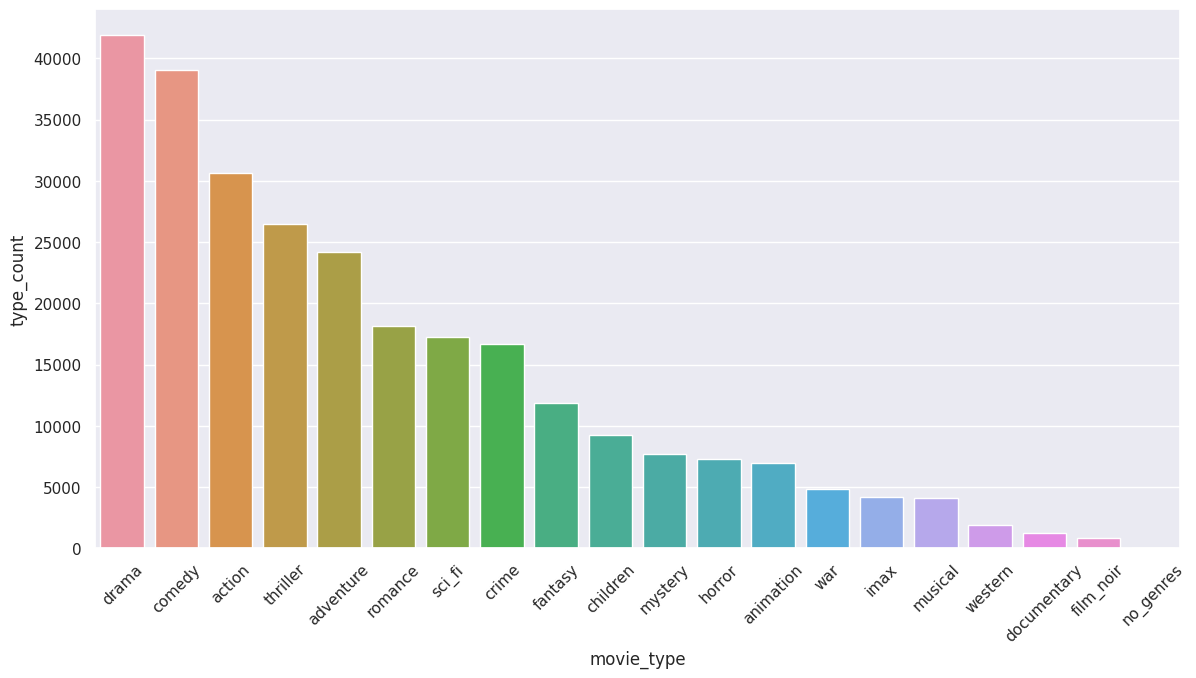

In [46]:
sns.set(rc={'figure.figsize':(14,7)})
sns.barplot(x = 'movie_type', y = 'type_count', data = movie_type_count)
plt.xticks(rotation=45)

Top 3 categories in the movie dataset is: Drama, Comedy, Action.

# Finding weighted score

**Weighted Score (WR) = (v / (v + m)) * R + (m / (v + m)) * C**

* v is the number of votes (ratings) for the movie.
* m is the minimum number of votes required to be listed.
* R is the average rating of the movie.
* C is the mean rating across all movies in the dataset.

>The IMDb formula is a weighted rating formula used by the Internet Movie Database (IMDb) to rank and score movies, used in recommendation systems. It's designed to provide a more balanced and fair representation of a movie's quality by taking into account both the average rating and the number of ratings it has received.

In [47]:
# some of the 5 star rated movies

df1 = movie_rating.groupby(['title']).agg({'rating':'mean'}).sort_values(by=['rating'],ascending=False).reset_index()
df1.head()

,title,rating
0,Vagabond (Sans toit ni loi) (1985),5.0
1,World of Glory (1991),5.0
2,Colourful (Karafuru) (2010),5.0
3,Come and See (Idi i smotri) (1985),5.0
4,When Worlds Collide (1951),5.0


In [48]:
# most rated movies

df2 = movie_rating.groupby(['title']).agg({'rating':'count'}).sort_values(by=['rating'],ascending=False).reset_index()
df2.head()

,title,rating
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278


In [49]:
# users with most number of rating

movie_rating.groupby(['userid']).agg({'rating':'count'}).sort_values(by=['rating'],ascending=False).head().reset_index()

,userid,rating
0,414,2697
1,599,2477
2,474,2107
3,448,1864
4,274,1346


### Finding avg rating and num of rating

In [50]:
df = pd.merge(df1, df2, on='title')
df.columns = ['title', 'mean_rating', 'no_of_ratings']
df.head()

,title,mean_rating,no_of_ratings
0,Vagabond (Sans toit ni loi) (1985),5.0,1
1,World of Glory (1991),5.0,1
2,Colourful (Karafuru) (2010),5.0,1
3,Come and See (Idi i smotri) (1985),5.0,2
4,When Worlds Collide (1951),5.0,1


In [51]:
df.shape

(9719, 3)

<Axes: >

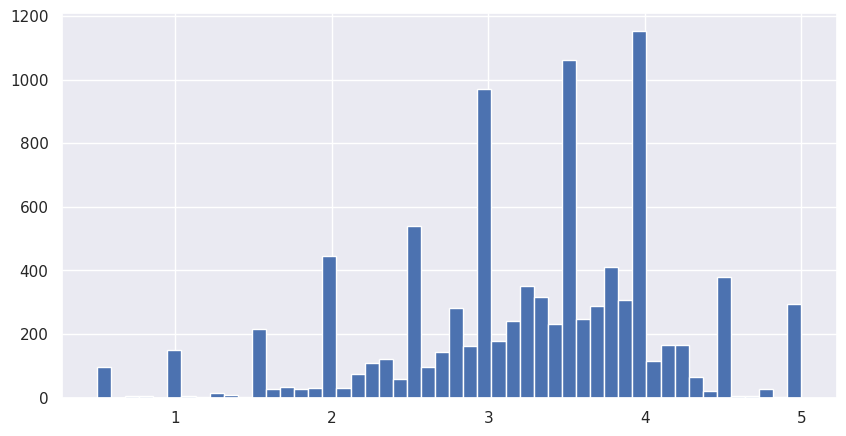

In [52]:
plt.figure(figsize=(10,5))
df['mean_rating'].hist(bins=50)

<Axes: >

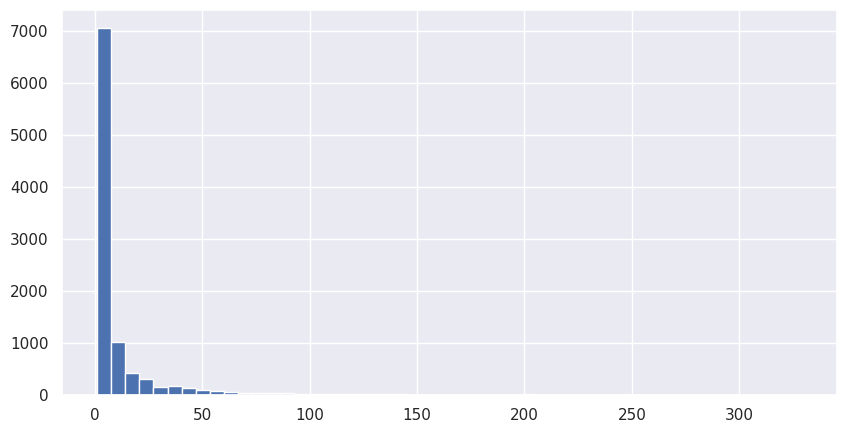

In [53]:
plt.figure(figsize=(10,5))
df['no_of_ratings'].hist(bins=50)

Lets calculate weighted score using formula: 

Weighted Rating (WR) = (v / (v + m)) * R + (m / (v + m)) * C

In [54]:
C = df['mean_rating'].mean()
C

3.2624701125899587

In [55]:
m = df['no_of_ratings'].quantile(0.7)
m

7.0

In [56]:
# considering only those movies eligible which has num of ratings > 70% quantile value

eligible = df.loc[df['no_of_ratings'] >= m]
eligible.shape

(2948, 3)

In [57]:
# calculation based on the IMDB formula

def weighted_rating(x, m=m, C=C):
    v = x['no_of_ratings']
    R = x['mean_rating']
    score = (v/(v+m) * R) + (m/(m+v) * C)
    return score

In [58]:
eligible['score'] = eligible.apply(weighted_rating, axis=1)
eligible.head()

,title,mean_rating,no_of_ratings,score
317,"Three Billboards Outside Ebbing, Missouri (2017)",4.750000,8,4.055819
340,Secrets & Lies (1996),4.590909,11,4.074294
341,"Day of the Doctor, The (2013)",4.571429,7,3.916949
342,Guess Who's Coming to Dinner (1967),4.545455,11,4.046516
343,Paths of Glory (1957),4.541667,12,4.070384


In [59]:
eligible = eligible.sort_values('score', ascending=False)

<BarContainer object of 10 artists>

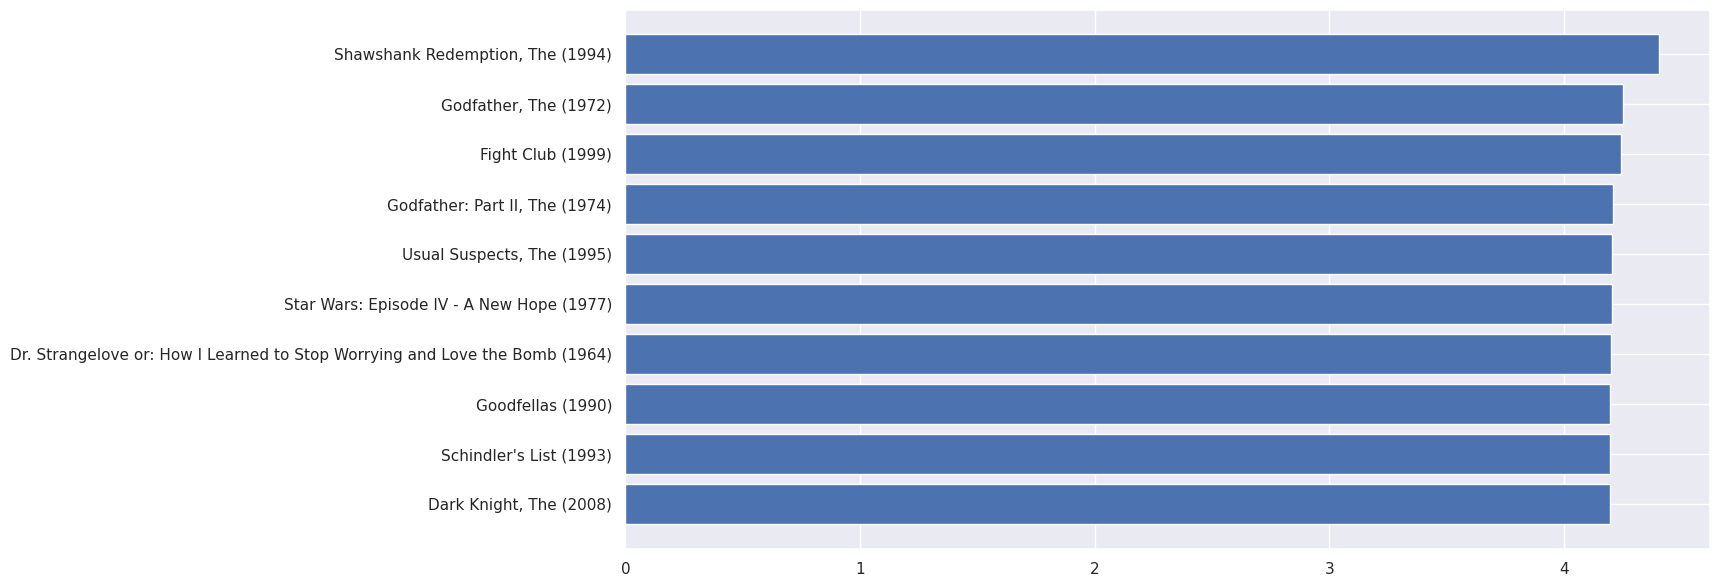

In [60]:
plt.gca().invert_yaxis()
plt.barh(eligible['title'].head(10), eligible['score'].head(10), align='center')

Shawshank Redemption got the highest weighted score.

# Genre Based Recommendation

In [61]:
eligible.shape

(2948, 4)

In [62]:
df_movies_new.shape

(9737, 23)

In [63]:
eligible_movies_full = pd.merge(df_movies_new, eligible, on='title')
eligible_movies_full.shape

(2948, 26)

In [64]:
eligible_movies_full.head(3)

,movieid,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,war,musical,documentary,imax,western,film_noir,no_genres,mean_rating,no_of_ratings,score
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,3.920930,215,3.900168
1,2,Jumanji (1995),Adventure Children Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,3.431818,110,3.421686
2,3,Grumpier Old Men (1995),Comedy Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,3.259615,52,3.259954


In [65]:
def genre_wise_movies(genre):
  return eligible_movies_full[eligible_movies_full[genre]==1].sort_values('score', ascending=False)[['title', 'genres', 'score']].head()

>Following are the recommended movies when genre is selected as 'adventure'.

In [66]:
genre_wise_movies('adventure')

,title,genres,score
152,Star Wars: Episode IV - A New Hope (1977),Action Adventure Sci-Fi,4.204796
546,"Princess Bride, The (1987)",Action Adventure Comedy Fantasy Romance,4.186827
545,Star Wars: Episode V - The Empire Strikes Back...,Action Adventure Sci-Fi,4.185033
547,Raiders of the Lost Ark (Indiana Jones and the...,Action Adventure,4.175542
553,Lawrence of Arabia (1962),Adventure Drama War,4.160333


>Following are the recommended movies when genre is selected as 'comedy'.

In [67]:
genre_wise_movies('comedy')

,title,genres,score
374,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy War,4.200359
546,"Princess Bride, The (1987)",Action Adventure Comedy Fantasy Romance,4.186827
171,Pulp Fiction (1994),Comedy Crime Drama Thriller,4.176233
204,Forrest Gump (1994),Comedy Drama Romance War,4.145349
1769,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy Romance,4.132577


>Following are the recommended movies when genre is selected as 'action'.

In [68]:
genre_wise_movies('action')

,title,genres,score
1276,Fight Club (1999),Action Crime Drama Thriller,4.241499
152,Star Wars: Episode IV - A New Hope (1977),Action Adventure Sci-Fi,4.204796
2479,"Dark Knight, The (2008)",Action Crime Drama IMAX,4.194470
546,"Princess Bride, The (1987)",Action Adventure Comedy Fantasy Romance,4.186827
545,Star Wars: Episode V - The Empire Strikes Back...,Action Adventure Sci-Fi,4.185033


# Item-based Collaborative Filtering

This method recommends items to users based on the ratings of items that the user has rated highly in the past.

## Recommend using Pearson Correlation

Measures the linear relationship between two variables
- Create a user-item matrix where rows represent users, columns represent items, and the values represent user ratings (or other forms of user-item interactions).
- Calculate the Pearson Correlation (or Pearson Correlation Coefficient) between users. This measure quantifies how similar one user's preferences are to another user. Users with a high positive correlation are considered similar.

In [69]:
movie_matrix = movie_rating.pivot_table(index='userid', columns='title', values='rating')
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
movie_matrix.shape

(610, 9719)

In [71]:
movie_matrix['Titanic (1997)'].tail()

userid
606    4.0
607    NaN
608    2.0
609    NaN
610    3.0
Name: Titanic (1997), dtype: float64

In [72]:
movie_matrix.corrwith(movie_matrix['Titanic (1997)']).sort_values(ascending=False).head()

title
Ip Man 2 (2010)                                               1.0
Mrs. Henderson Presents (2005)                                1.0
Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)    1.0
Thesis (Tesis) (1996)                                         1.0
Hand That Rocks the Cradle, The (1992)                        1.0
dtype: float64

Above are the top correlated/recommended movies with Titanic.

## Recommend using Cosine Similarity

In [73]:
eligible_movies_full['indexcol'] = eligible_movies_full.index

In [74]:
# getting the count matrix

tf = TfidfVectorizer()
count_matrix = tf.fit_transform(eligible_movies_full['genres'])

In [75]:
print(count_matrix[:5])

  (0, 8)	0.47391857950291805
  (0, 4)	0.2792181929787865
  (0, 3)	0.5015993194953707
  (0, 2)	0.5465762988762775
  (0, 1)	0.3835242533401098
  (1, 8)	0.6002858627265061
  (1, 3)	0.6353474906219688
  (1, 1)	0.4857884819250674
  (2, 19)	0.8174255256798652
  (2, 4)	0.5760342958253407
  (3, 7)	0.4884830239900367
  (3, 19)	0.7132637687306668
  (3, 4)	0.5026322029970574
  (4, 4)	1.0


In [76]:
# cosine similarity matrix from the count matrix

cosine_sim = cosine_similarity(count_matrix)

In [77]:
cosine_sim.shape

(2948, 2948)

In [78]:
cosine_sim[0]       # checking similarity values of movie at 1st index

array([1.        , 0.78948816, 0.16083926, ..., 0.40112971, 0.55698307,
       0.10373173])

In [79]:
list(enumerate(cosine_sim[0]))[0:5]    # just enumerating above values

[(0, 1.0),
 (1, 0.7894881571096374),
 (2, 0.16083925517415937),
 (3, 0.14034405545378498),
 (4, 0.2792181929787865)]

**Finding top 5 similar movies to Titanic**

In [80]:
movie_name = 'Titanic (1997)'

In [81]:
# finding index id for Titanic

eligible_movies_full[eligible_movies_full['title'] == movie_name]['indexcol']

783    783
Name: indexcol, dtype: int64

In [82]:
eligible_movies_full[eligible_movies_full['title'] == movie_name]['indexcol'].values[0]

783

In [83]:
# getting titanic index from data frame by passing movie name and then finding its similarity values with rest of the movies

indexcol_value = eligible_movies_full[eligible_movies_full['title'] == movie_name]['indexcol'].values[0]
similar_movies = list(enumerate(cosine_sim[indexcol_value]))

In [84]:
len(similar_movies)

2948

In [85]:
similar_movies[0:10]    # indexcol, cosine similarity

[(0, 0.0),
 (1, 0.0),
 (2, 0.6744242566144796),
 (3, 0.8645003577271237),
 (4, 0.0),
 (5, 0.0),
 (6, 0.6744242566144796),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0)]

In [86]:
# sorting in descending order of cosine similarity
# discard the first element after sorting the movies as its similarity with itself

sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]

In [87]:
sorted_similar_movies[0:10]

[(24, 1.0),
 (27, 1.0),
 (39, 1.0),
 (55, 1.0),
 (60, 1.0),
 (73, 1.0),
 (82, 1.0),
 (122, 1.0),
 (124, 1.0),
 (127, 1.0)]

In [88]:
# getting top 5 similar movie names by passing above indexes

i=0
print('Top 5 similar movies to '+ movie_name +' are:\n')
for element in sorted_similar_movies:
    print(eligible_movies_full[eligible_movies_full['indexcol'] == element[0]]['title'].values[0])
    i=i+1
    if i>4:
        break

Top 5 similar movies to Titanic (1997) are:

Leaving Las Vegas (1995)
Persuasion (1995)
How to Make an American Quilt (1995)
Bed of Roses (1996)
Angels and Insects (1995)


## Recommend using KNN algorithm (with Cosine distance metric)

In [89]:
rating_matrix = movie_rating.pivot_table(index='title', columns='userid', values='rating')
rating_matrix.head(3)

userid,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
rating_matrix.shape

(9719, 610)

In [91]:
rating_matrix.fillna(0, inplace=True)
rating_matrix.head(3)

userid,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# converting to array matrix

rating_matrix_new = csr_matrix(rating_matrix.values)

In [93]:
rating_matrix_new.shape

(9719, 610)

In [94]:
print(rating_matrix_new[:5])

  (0, 609)	4.0
  (1, 331)	4.0
  (2, 331)	3.5
  (2, 376)	3.5
  (3, 344)	5.0
  (4, 112)	3.0
  (4, 344)	5.0


In [95]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_matrix_new)

NearestNeighbors(algorithm='brute', metric='cosine')

In [96]:
query_index = 5617          # passing a random index num

distances, indices = model_knn.kneighbors(rating_matrix.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [97]:
distances, indices

(array([[0., 0., 0., 0., 0., 0.]]),
 array([[7748, 3692, 3784, 6992, 8580, 4070]]))

In [98]:
rating_matrix.index[:5]

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)'],
      dtype='object', name='title')

In [99]:
for i in range(len(distances[0])):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_matrix.index[query_index]))
    else:
        print('{0}: {1}'.format(i, rating_matrix.index[indices[0][i]]))

Recommendations for Mezzo Forte (1998):

1: Guyver: Dark Hero (1994)
2: Harrison Bergeron (1995)
3: Real Life (1979)
4: The Punisher: Dirty Laundry (2012)
5: House of Cards (1993)


## Clustering of movies

* Calculate the within-cluster sum of squares (inertia) for each cluster. This is a common approach to determine the optimal number of clusters. 
* Create plot can help you identify the optimal number of clusters by looking for an "elbow" point where the inertia starts to level off.

In [100]:
count_matrix.shape

(2948, 24)

In [101]:
print(count_matrix[:5])

  (0, 8)	0.47391857950291805
  (0, 4)	0.2792181929787865
  (0, 3)	0.5015993194953707
  (0, 2)	0.5465762988762775
  (0, 1)	0.3835242533401098
  (1, 8)	0.6002858627265061
  (1, 3)	0.6353474906219688
  (1, 1)	0.4857884819250674
  (2, 19)	0.8174255256798652
  (2, 4)	0.5760342958253407
  (3, 7)	0.4884830239900367
  (3, 19)	0.7132637687306668
  (3, 4)	0.5026322029970574
  (4, 4)	1.0


Cluster: 1    Intertia: 2333.972704789093
Cluster: 2    Intertia: 2009.2485747508126
Cluster: 3    Intertia: 1783.1592247564154
Cluster: 4    Intertia: 1625.1539854227199
Cluster: 5    Intertia: 1467.3763712652617
Cluster: 6    Intertia: 1334.882013301851
Cluster: 7    Intertia: 1216.4885686582
Cluster: 8    Intertia: 1140.924414839866
Cluster: 9    Intertia: 1060.4529614529572
Cluster: 10    Intertia: 991.1347139302213
Cluster: 11    Intertia: 938.0815708372377
Cluster: 12    Intertia: 893.3710341406065
Cluster: 13    Intertia: 857.1171855789601
Cluster: 14    Intertia: 805.5043170562789


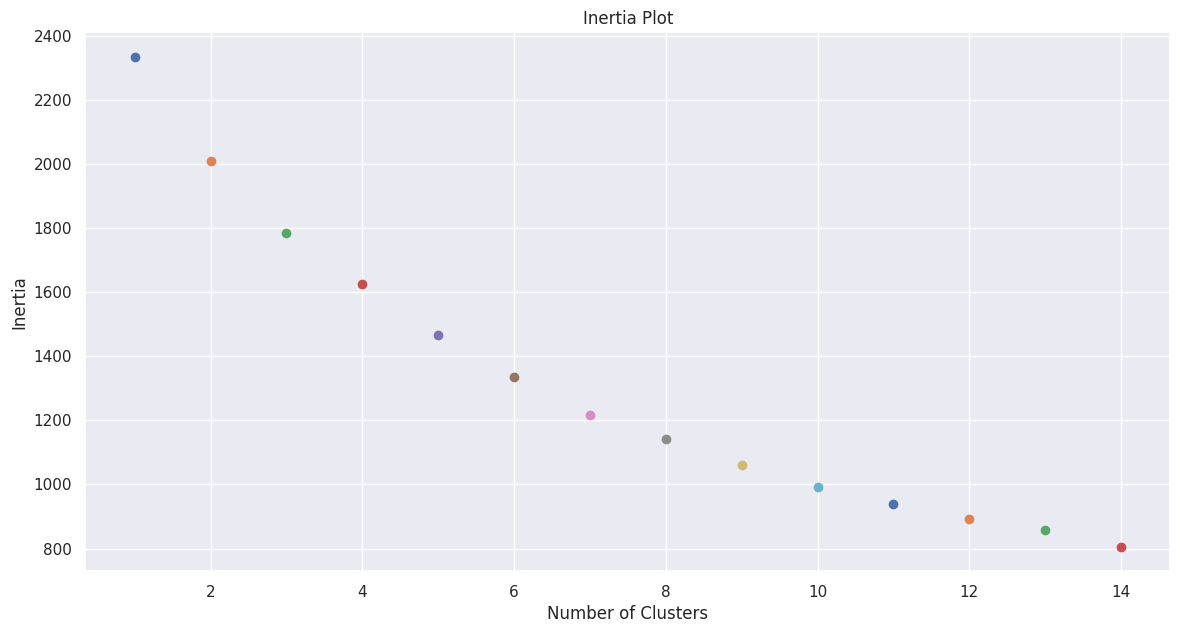

In [102]:
inertia = []

for n_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(count_matrix)
    inertia.append(kmeans.inertia_ / n_clusters)
    print("Cluster:", n_clusters,"  ","Intertia:", kmeans.inertia_)
    plt.plot(n_clusters, kmeans.inertia_, marker='o')
    
# Create the inertia plot
plt.title('Inertia Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [103]:
# create a KMeans object with 6 clusters
km = KMeans(n_clusters=6)

# fit the k-means object with tfidf_matrix
km.fit(count_matrix)

clusters = km.labels_.tolist()

In [104]:
len(clusters)

2948

In [105]:
eligible_movies_full.shape

(2948, 27)

In [106]:
eligible_movies_full.tail(3)

,movieid,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,musical,documentary,imax,western,film_noir,no_genres,mean_rating,no_of_ratings,score,indexcol
2945,179819,Star Wars: The Last Jedi (2017),Action Adventure Fantasy Sci-Fi,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3.1250,12,3.175647,2945
2946,180031,The Shape of Water (2017),Adventure Drama Fantasy,1,0,0,0,1,0,1,...,0,0,0,0,0,0,3.6875,8,3.489153,2946
2947,187593,Deadpool 2 (2018),Action Comedy Sci-Fi,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3.8750,12,3.649331,2947


In [107]:
eligible_movies_upd = eligible_movies_full[['movieid', 'title', 'genres', 'mean_rating', 'no_of_ratings', 'score']]

In [108]:
# adding a column 'cluster' showing which movie belong to which cluster

eligible_movies_upd['cluster'] = clusters
eligible_movies_upd.head()

,movieid,title,genres,mean_rating,no_of_ratings,score,cluster
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.920930,215,3.900168,5
1,2,Jumanji (1995),Adventure Children Fantasy,3.431818,110,3.421686,5
2,3,Grumpier Old Men (1995),Comedy Romance,3.259615,52,3.259954,3
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2.357143,7,2.809806,3
4,5,Father of the Bride Part II (1995),Comedy,3.071429,49,3.095309,1


In [109]:
# Display number of films per cluster (clusters from 0 to 4)
eligible_movies_upd['cluster'].value_counts()

cluster
4    689
5    554
1    484
3    451
2    423
0    347
Name: count, dtype: int64

In [110]:
# storing movie names in respective clusters

cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for row in range(len(eligible_movies_upd)):

  if eligible_movies_upd['cluster'].iloc[row]==0:
    cluster0.append(eligible_movies_upd['title'].iloc[row])

  elif eligible_movies_upd["cluster"].iloc[row]==1:
    cluster1.append(eligible_movies_upd['title'].iloc[row])

  elif eligible_movies_upd["cluster"].iloc[row]==2:
    cluster2.append(eligible_movies_upd['title'].iloc[row])

  elif eligible_movies_upd["cluster"].iloc[row]==3:
    cluster3.append(eligible_movies_upd['title'].iloc[row])

  elif eligible_movies_upd["cluster"].iloc[row]==4:
    cluster4.append(eligible_movies_upd['title'].iloc[row])
    
  else:
    cluster5.append(eligible_movies_upd['title'].iloc[row])

In [111]:
print("First 5 movies in Cluster 0:")
i=0

for element in cluster0:
  print(element)
  i=i+1
  if i>4:
    break

First 5 movies in Cluster 0:
Nixon (1995)
Othello (1995)
Dangerous Minds (1995)
Richard III (1995)
Restoration (1995)


In [112]:
print("First 5 movies in Cluster 3:")
i=0

for element in cluster3:
  print(element)
  i=i+1
  if i>4:
    break

First 5 movies in Cluster 3:
Grumpier Old Men (1995)
Waiting to Exhale (1995)
Sabrina (1995)
American President, The (1995)
Cutthroat Island (1995)


# Content latent matrix using TFIDF & SVD

In [113]:
df_tags.head()

,userid,movieid,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [114]:
df_movies.shape

(9737, 3)

In [115]:
df_tags.drop(['timestamp'],axis=1, inplace=True)

In [116]:
df_tags.shape

(3683, 3)

In [117]:
movie_tags = pd.merge(df_movies, df_tags, on='movieid', how='left')
movie_tags.head()

,movieid,title,genres,userid,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [118]:
movie_tags.shape

(11848, 5)

In [119]:
movie_tags.isnull().sum()

movieid       0
title         0
genres        0
userid     8166
tag        8166
dtype: int64

In [120]:
movie_tags.fillna('', inplace=True)

In [121]:
movie_tags['tag'] = movie_tags.groupby(['title'])['tag'].transform(lambda x : ' '.join(x))

In [122]:
movie_tags = movie_tags[['movieid', 'title', 'genres', 'tag']]

In [123]:
movie_tags.head(5)

,movieid,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun
3,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game
4,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game


In [124]:
movie_tags = movie_tags.drop_duplicates().reset_index(drop=True)

In [125]:
movie_tags.sample(5, random_state=15)

,movieid,title,genres,tag
8795,130444,Ruby Red (2013),Adventure Children Fantasy Sci-Fi,
767,1009,Escape to Witch Mountain (1975),Adventure Children Fantasy,
4405,6484,Hollywood Homicide (2003),Action Crime Drama,
4996,7714,Camelot (1967),Drama Musical Romance,King Arthur
4101,5878,Talk to Her (Hable con Ella) (2002),Drama Romance,coma


In [126]:
movie_tags.shape

(9737, 4)

'metadata' will have collection of genres, tags, movie names.

In [127]:
movie_tags['metadata'] = movie_tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)
movie_tags = movie_tags[['movieid','title','metadata']]

In [128]:
movie_tags.head()

,movieid,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy


In [129]:
def clean(review):
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    return review

movie_tags['title2'] = pd.DataFrame(movie_tags['title'].apply(lambda x: clean(x)))

In [130]:
movie_tags.head()

,movieid,title,metadata,title2
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...,toy story
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...,jumanji
2,3,Grumpier Old Men (1995),moldy old Comedy Romance,grumpier old men
3,4,Waiting to Exhale (1995),Comedy Drama Romance,waiting to exhale
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy,father of the bride part ii


In [131]:
movie_tags['metadata'] = movie_tags['metadata'] + ' ' + movie_tags['title2']
movie_tags = movie_tags[['movieid', 'title', 'metadata']]

In [132]:
movie_tags.head()

,movieid,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance grumpier old men
3,4,Waiting to Exhale (1995),Comedy Drama Romance waiting to exhale
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy father of the bride pa...


Aligning (filtering and sorting) movie_tags same as the rows of rating_matrix.

In [133]:
movie_list = list(rating_matrix.index)

In [134]:
# dictionary has the order for sorting

movie_list_index = dict(zip(movie_list, range(len(movie_list))))

In [135]:
# first filtering the movies which are present in rating_matrix

movie_tags_new = movie_tags[movie_tags['title'].isin(movie_list)]
movie_tags_new.head()

,movieid,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance grumpier old men
3,4,Waiting to Exhale (1995),Comedy Drama Romance waiting to exhale
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy father of the bride pa...


In [136]:
# titleorder has the ordering of movies just like it is in rating_matrix

movie_tags_new['titleorder'] = movie_tags_new['title'].map(movie_list_index)

In [137]:
movie_tags_new.head()

,movieid,title,metadata,titleorder
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...,8871
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...,4645
2,3,Grumpier Old Men (1995),moldy old Comedy Romance grumpier old men,3661
3,4,Waiting to Exhale (1995),Comedy Drama Romance waiting to exhale,9225
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy father of the bride pa...,2967


In [138]:
# sorting movies to align with rating_matrix

movie_tags_new.sort_values(['titleorder'], inplace=True)
movie_tags_new.drop(['titleorder'], axis = 1, inplace=True)

In [139]:
movie_tags_new.head(5)

,movieid,title,metadata
8596,117867,'71 (2014),Action Drama Thriller War
8010,97757,'Hellboy': The Seeds of Creation (2004),Action Adventure Comedy Documentary Fantasy ...
5527,26564,'Round Midnight (1986),Drama Musical round midnight
5688,27751,'Salem's Lot (2004),Drama Horror Mystery Thriller salem s lot ...
614,779,'Til There Was You (1997),Drama Romance til there was you


In [140]:
# apply tf-idf on metadata column

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_tags_new['metadata'])

In [141]:
tfidf_matrix.shape

(9719, 9658)

In [142]:
print(tfidf_matrix[:5])

  (0, 9281)	0.7067204360584505
  (0, 8594)	0.4482517819092638
  (0, 2465)	0.30658473642686146
  (0, 54)	0.4534560228540306
  (1, 1924)	0.5128805555593192
  (1, 7521)	0.5532984724891767
  (1, 3858)	0.5128805555593192
  (1, 2907)	0.20548291618657
  (1, 2378)	0.2389247971935921
  (1, 1715)	0.1137078242917728
  (1, 87)	0.1769828985139924
  (1, 54)	0.155586530809556
  (2, 5531)	0.5834863472497289
  (2, 7243)	0.7268724872027492
  (2, 5807)	0.3348175007721707
  (2, 2465)	0.13819302116074966
  (3, 5120)	0.6412905155546056
  (3, 7342)	0.6412905155546056
  (3, 5820)	0.2692541675995737
  (3, 4015)	0.23258654166042889
  (3, 8594)	0.1862173629554721
  (3, 2465)	0.12736458268305373
  (4, 8632)	0.9433970737079742
  (4, 7199)	0.2789846308885248
  (4, 2465)	0.17935868266472238


In [143]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [144]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index = movie_tags_new.index.tolist())
tfidf_df.shape

(9719, 9658)

In [145]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9648,9649,9650,9651,9652,9653,9654,9655,9656,9657
8596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
# compress to 1000 components with SVD

svd = TruncatedSVD(n_components=1000)
latent_matrix1 = svd.fit_transform(tfidf_df)

In [147]:
# our content latent matrix

latent_matrix1.shape

(9719, 1000)

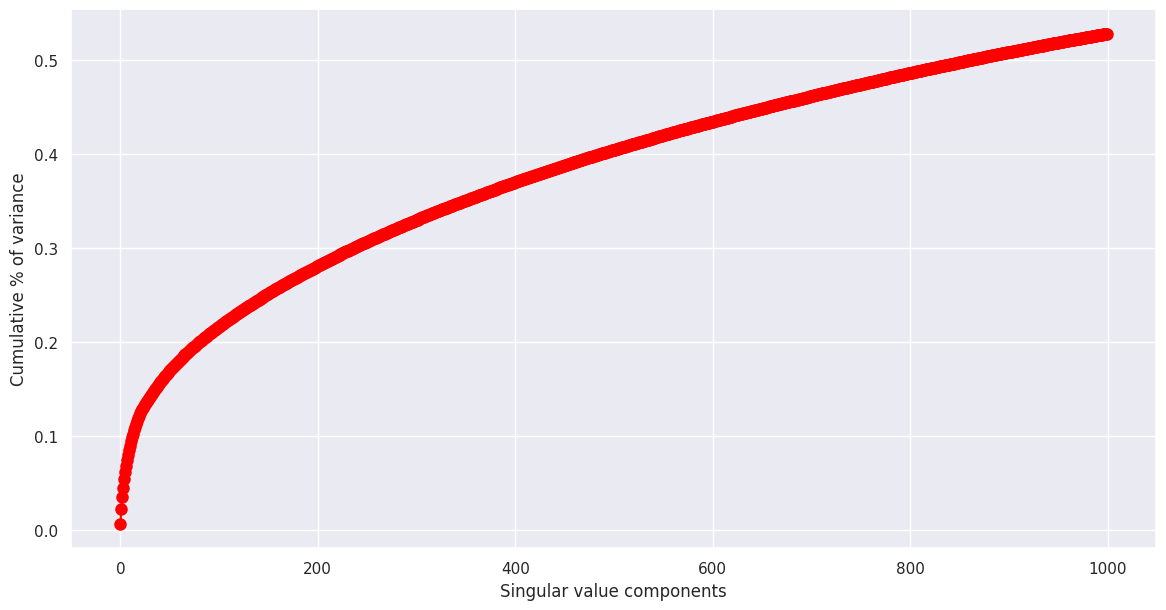

In [148]:
# plot var expalined to see what latent dimensions to use

explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative % of variance', fontsize=12)        
plt.show()

In [149]:
# number of latent dimensions to keep

n = 1000 
latent_matrix1_df = pd.DataFrame(latent_matrix1[:,0:n], index=movie_tags_new['title'].tolist())
latent_matrix1_df.shape

(9719, 1000)

In [150]:
latent_matrix1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
'71 (2014),0.497114,-0.140048,-0.319958,-0.182239,-0.244774,0.008523,0.072336,0.480542,0.048773,0.247268,...,0.001509,0.002200,-0.002541,0.000498,-0.000685,-0.001827,-0.001309,-0.000746,-0.000583,0.002829
'Hellboy': The Seeds of Creation (2004),0.170655,-0.001997,0.131311,-0.158214,0.015641,-0.009119,0.064896,0.106466,0.200518,-0.065109,...,0.014625,-0.027484,0.052671,0.004574,-0.017114,-0.034688,-0.007455,0.041494,0.059116,-0.035681
'Round Midnight (1986),0.080702,0.065151,-0.027310,0.006792,-0.071945,-0.075577,-0.063840,-0.018240,0.014362,-0.029044,...,0.000577,-0.005803,0.002841,-0.004281,-0.005123,0.000723,-0.010363,-0.005099,0.004478,0.001627
'Salem's Lot (2004),0.198755,-0.087827,-0.193392,0.096691,0.127276,-0.190616,-0.010038,0.006956,0.007045,0.114044,...,-0.005074,-0.028513,0.001834,-0.018963,0.007238,0.011569,0.007694,-0.021109,0.018632,0.021890
'Til There Was You (1997),0.153776,0.172139,-0.046148,0.116651,-0.128690,-0.041730,0.124823,-0.046495,0.003138,-0.031991,...,-0.000915,-0.000117,-0.001554,-0.002815,0.000936,0.000425,0.000214,-0.001004,-0.000038,0.000800


# Collaborative latent matrix using TFIDF & SVD

In [151]:
rating_matrix.head(3)

userid,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
rating_matrix.shape

(9719, 610)

In [153]:
svd = TruncatedSVD(n_components=100)
latent_matrix2 = svd.fit_transform(rating_matrix)

In [154]:
latent_matrix2.shape

(9719, 100)

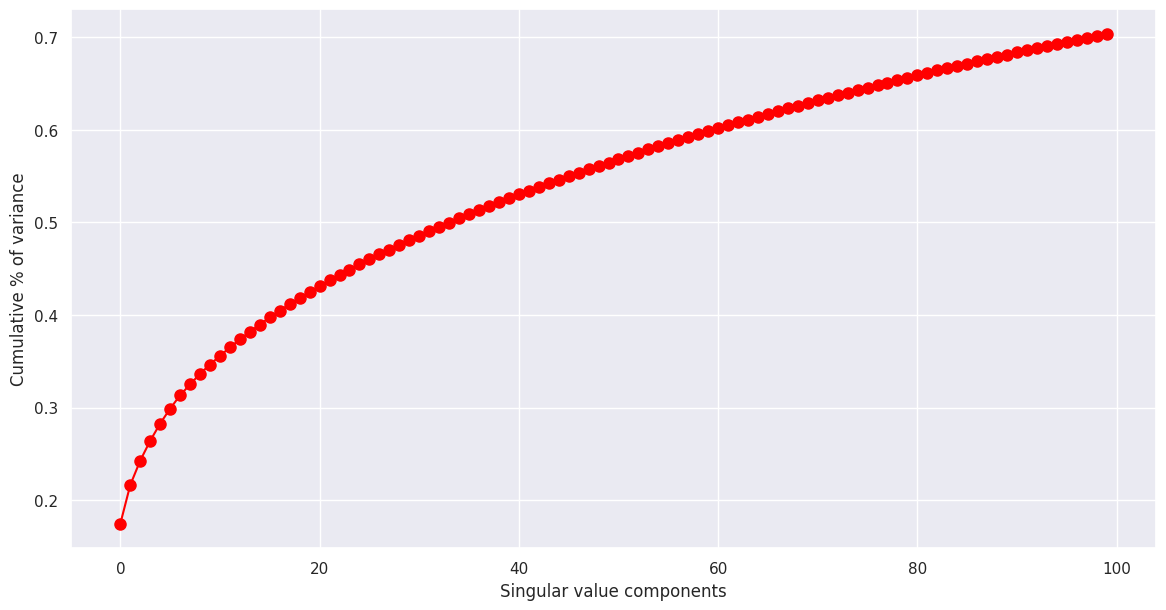

In [155]:
# plot var expalined to see what latent dimensions to use

explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative % of variance', fontsize=12)        
plt.show()

In [156]:
# number of latent dimensions to keep
n = 100 
latent_matrix2_df = pd.DataFrame(latent_matrix2[:,0:n], index=rating_matrix.index.tolist())
latent_matrix2_df.shape

(9719, 100)

In [157]:
latent_matrix2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
'71 (2014),0.555182,0.809224,-0.368420,-0.065336,0.632934,-1.006283,-0.251455,-0.833241,-0.779589,0.291697,...,0.033217,-0.012029,-0.028875,0.143654,-0.049087,-0.056025,-0.113477,-0.017574,0.045363,0.009705
'Hellboy': The Seeds of Creation (2004),0.234890,0.048631,0.027845,0.324393,0.026623,0.039645,-0.101649,0.047963,-0.100788,-0.030061,...,-0.346756,0.484417,0.220762,-0.554177,0.072501,-0.085481,-0.260889,-0.109333,0.358366,0.210681
'Round Midnight (1986),0.251241,-0.004923,-0.014241,0.287647,0.065669,0.025886,-0.049847,-0.037447,-0.109659,0.009807,...,-0.370934,0.152175,0.087068,-0.385250,0.119108,-0.176586,-0.106220,0.031614,0.362721,0.064462
'Salem's Lot (2004),0.034917,-0.053290,-0.047510,0.007676,0.015763,0.008245,0.056545,-0.038698,-0.013110,-0.014476,...,-0.083175,-0.164653,-0.088607,0.018731,0.063691,-0.066839,0.017537,0.218212,0.044976,-0.035988
'Til There Was You (1997),0.084489,-0.152986,-0.101741,0.062784,-0.071298,-0.046116,0.169120,-0.065376,0.036404,-0.066302,...,-0.008419,-0.349487,-0.251352,0.085235,0.110531,-0.078236,-0.100499,0.419087,-0.133277,-0.266884


## Comparing above two

In [158]:
# checking latent matrix1 with Toy Story

latent_matrix1_df.loc['Toy Story (1995)']

0      0.127145
1      0.038424
2      0.184619
3     -0.158875
4      0.040615
         ...   
995   -0.020028
996   -0.006634
997   -0.003709
998    0.002059
999   -0.012742
Name: Toy Story (1995), Length: 1000, dtype: float64

In [159]:
# checking latent matrix2 with Toy Story

latent_matrix2_df.loc['Toy Story (1995)']

0     37.651948
1     -6.387467
2     14.981189
3      0.295198
4     -1.890664
        ...    
95    -1.893474
96    -2.584492
97     0.181499
98    -1.198430
99     2.391650
Name: Toy Story (1995), Length: 100, dtype: float64

In [160]:
# checking cosine similarity of latent matrix1 with Toy Story

cosine_similarity(latent_matrix1_df, np.array(latent_matrix1_df.loc['Toy Story (1995)']).reshape(1, -1))

array([[-0.00027651],
       [ 0.16640036],
       [ 0.00158048],
       ...,
       [-0.00479656],
       [ 0.03951617],
       [ 0.01514888]])

Now finding similarity for the movie Batman Begins.

In [161]:
# taking latent vectors for Batman Begins
content = np.array(latent_matrix1_df.loc['Batman Begins (2005)']).reshape(1, -1)            # content based
collaborative = np.array(latent_matrix2_df.loc['Batman Begins (2005)']).reshape(1, -1)      # collaborative based

# finding similartity of Batman Begins with the others in the list
score_1 = cosine_similarity(latent_matrix1_df, content).reshape(-1)
score_2 = cosine_similarity(latent_matrix2_df, collaborative).reshape(-1)

# finding average score of both content and collaborative 
average = ((score_1 + score_2)/2)

# forming data frame
scoresdict = {'content': score_1 , 'collaborative': score_2, 'average': average} 
similar = pd.DataFrame(scoresdict, index = latent_matrix1_df.index)

In [162]:
# sort on basis of content column 
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)    # restricting to first 10 movies

,content,collaborative,average
Batman (1966),0.668015,0.146520,0.407267
Batman: Mystery of the Batwoman (2003),0.635151,0.137875,0.386513
Batman: Assault on Arkham (2014),0.603678,0.137875,0.370776
Batman (1989),0.588383,0.365442,0.476912
Batman: Year One (2011),0.573383,0.201235,0.387309
Batman: The Killing Joke (2016),0.551965,0.137875,0.344920
Batman Beyond: Return of the Joker (2000),0.531331,0.179885,0.355608
Batman: Gotham Knight (2008),0.529258,0.191601,0.360429
Batman & Robin (1997),0.513458,0.390792,0.452125
Batman Returns (1992),0.499706,0.420145,0.459926


In [163]:
# sort on basis of collaborative column 
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,average
V for Vendetta (2006),0.405664,0.841329,0.623496
"Dark Knight, The (2008)",0.211839,0.812081,0.511960
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.034175,0.804012,0.419093
Iron Man (2008),0.065393,0.792457,0.428925
"Prestige, The (2006)",-0.004535,0.776163,0.385814
Kill Bill: Vol. 1 (2003),0.101716,0.773375,0.437546
Sin City (2005),0.110500,0.772096,0.441298
"Lord of the Rings: The Return of the King, The (2003)",0.022526,0.771310,0.396918
300 (2007),0.398398,0.768129,0.583264
"Matrix Reloaded, The (2003)",0.371132,0.767849,0.569491


In [164]:
# sort on basis of average column 
similar.sort_values('average', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,average
V for Vendetta (2006),0.405664,0.841329,0.623496
300 (2007),0.398398,0.768129,0.583264
"Matrix Reloaded, The (2003)",0.371132,0.767849,0.569491
"Matrix Revolutions, The (2003)",0.371132,0.719955,0.545543
"Dark Knight, The (2008)",0.211839,0.812081,0.511960
Watchmen (2009),0.357806,0.633801,0.495804
Batman (1989),0.588383,0.365442,0.476912
Thor (2011),0.394978,0.548711,0.471844
Spider-Man 2 (2004),0.223428,0.711458,0.467443
Batman Returns (1992),0.499706,0.420145,0.459926


# Using Surprise Library

## Using SVD

In [165]:
df_rating.head()

,userid,movieid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [166]:
df_rating.shape

(100836, 4)

In [167]:
reader = Reader()
data = Dataset.load_from_df(df_rating[['userid', 'movieid', 'rating']], reader)

In [168]:
data.__dict__['raw_ratings'][:5]

[(1, 1, 4.0, None),
 (1, 3, 4.0, None),
 (1, 6, 4.0, None),
 (1, 47, 5.0, None),
 (1, 50, 5.0, None)]

In [169]:
svd = SVD()         # using SVD
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)    # run 5-fold cross-validation and then print results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8779  0.8705  0.8782  0.8721  0.8696  0.8737  0.0037  
MAE (testset)     0.6751  0.6707  0.6723  0.6704  0.6708  0.6719  0.0018  
Fit time          1.15    1.16    1.11    1.18    1.17    1.16    0.02    
Test time         0.26    0.13    0.13    0.26    0.13    0.18    0.06    


{'test_rmse': array([0.87789335, 0.87053206, 0.87823803, 0.87208851, 0.86960882]),
 'test_mae': array([0.67512013, 0.67074303, 0.67234167, 0.67035897, 0.67077765]),
 'fit_time': (1.146686315536499,
  1.1643412113189697,
  1.1148312091827393,
  1.1835441589355469,
  1.1746833324432373),
 'test_time': (0.25769925117492676,
  0.12633824348449707,
  0.12752366065979004,
  0.25679492950439453,
  0.1296379566192627)}

In [170]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [171]:
df_rating[df_rating['userid'] == 26]

,userid,movieid,rating,timestamp
4038,26,10,3.0,836950403
4039,26,34,3.0,836950483
4040,26,47,4.0,836950431
4041,26,150,3.0,836950245
4042,26,153,3.0,836950286
4043,26,165,4.0,836950286
4044,26,185,3.0,836950403
4045,26,208,2.0,836950403
4046,26,225,3.0,836950483
4047,26,288,3.0,836950431


In [172]:
# checking predition for movieid 400 by giving userid, movieid

svd.predict(26, 400)        

Prediction(uid=26, iid=400, r_ui=None, est=3.2369094783705554, details={'was_impossible': False})

>SVD gives predition of 3.23 by user 26 for movieid 400.

## Using KNN Basic

In [173]:
knn = KNNBasic()         # using KNN Basic
cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)    # run 5-fold cross-validation and then print results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9362  0.9525  0.9514  0.9445  0.9495  0.9468  0.0060  
MAE (testset)     0.7218  0.7266  0.7273  0.7230  0.7299  0.7257  0.0029  
Fit time          0.14    0.16    0.15    0.16    0.16    0.15    0.01    
Test time         1.25    1.29    1.28    1.41    1.29    1.31    0.06    


{'test_rmse': array([0.93622257, 0.95247721, 0.95144941, 0.94451288, 0.94946511]),
 'test_mae': array([0.72183719, 0.72662849, 0.72731367, 0.72304411, 0.72986109]),
 'fit_time': (0.13977479934692383,
  0.15742111206054688,
  0.15186762809753418,
  0.16214799880981445,
  0.1604471206665039),
 'test_time': (1.2521226406097412,
  1.2943637371063232,
  1.2792906761169434,
  1.413163185119629,
  1.2896387577056885)}

In [174]:
trainset = data.build_full_trainset()
knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [175]:
knn.predict(26, 400)

Prediction(uid=26, iid=400, r_ui=None, est=3.501556983616962, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

>KNN Basic gives predition of 3.50 by user 26 for movieid 400.

## Using NMF

In [176]:
nmf = NMF()         # using NMF
cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)    # run 5-fold cross-validation and then print results

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9270  0.9267  0.9237  0.9168  0.9162  0.9221  0.0047  
MAE (testset)     0.7117  0.7110  0.7061  0.7056  0.7013  0.7071  0.0038  
Fit time          2.78    2.79    2.82    2.75    2.68    2.76    0.05    
Test time         0.11    0.12    0.12    0.11    0.11    0.11    0.01    


{'test_rmse': array([0.92702696, 0.92671781, 0.92372024, 0.91677637, 0.91619178]),
 'test_mae': array([0.71170918, 0.7110162 , 0.70610551, 0.70557543, 0.70130868]),
 'fit_time': (2.7805042266845703,
  2.7907748222351074,
  2.8156466484069824,
  2.751720428466797,
  2.6841304302215576),
 'test_time': (0.11264848709106445,
  0.12368154525756836,
  0.1173405647277832,
  0.1083528995513916,
  0.10904574394226074)}

In [177]:
trainset = data.build_full_trainset()
nmf.fit(trainset)

In [178]:
nmf.predict(26, 400)

Prediction(uid=26, iid=400, r_ui=None, est=3.501556983616962, details={'was_impossible': True, 'reason': 'User and item are unknown.'})

>NMF gives predition of 3.50 by user 26 for movieid 400.

## Using KNN Basic to get recommendations

In [179]:
len(data.__dict__['raw_ratings'])

100836

In [180]:
train_ratings, test_ratings = train_test_split(data, test_size=0.2)
print("Size of trainset: ", train_ratings.n_ratings)
print("Size of testset: ", len(test_ratings))

Size of trainset:  80668
Size of testset:  20168


In [181]:
knn.fit(train_ratings)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [182]:
train_predictions = knn.test(train_ratings.build_testset())
test_predictions = knn.test(test_ratings)

print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.7104433684269144
RMSE on test data:  0.9522532567784411


In [183]:
train_predictions[:5]

[Prediction(uid=509, iid=106072, r_ui=3.5, est=3.2957004657839812, details={'actual_k': 14, 'was_impossible': False}),
 Prediction(uid=509, iid=43928, r_ui=2.0, est=1.9925872418439357, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=509, iid=4519, r_ui=3.0, est=3.404609282025761, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid=509, iid=912, r_ui=3.0, est=4.115913240179368, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=509, iid=89745, r_ui=4.5, est=4.1034922878116005, details={'actual_k': 40, 'was_impossible': False})]

In [184]:
test_predictions[:5]

[Prediction(uid=600, iid=353, r_ui=3.5, est=3.567587833751783, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=165, iid=2194, r_ui=4.0, est=3.8423763792522174, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=156, iid=898, r_ui=5.0, est=4.325330186405035, details={'actual_k': 24, 'was_impossible': False}),
 Prediction(uid=20, iid=4090, r_ui=3.5, est=3.415455696416221, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=64, iid=1348, r_ui=4.0, est=3.547956191236809, details={'actual_k': 10, 'was_impossible': False})]

In [185]:
def top5movies(userid, predictions, n=5):
    predict_ratings = {}
    
    for uid, iid, r_ui, est, _ in predictions:          # loop for getting predictions for the user
        if (uid==userid):
            predict_ratings[iid] = est
    predict_ratings = sorted(predict_ratings.items(), key=lambda kv: kv[1], reverse=True)[:n]       # return tuples of (movieid, predicted rating)
    top_movies = [i[0] for i in predict_ratings]          # return list of movieids
    top_movies = [str(i) for i in top_movies]             # return list of movieids as string
    print('Recommended movies for user {} :'.format(userid))
    print()
    print(df_movies[df_movies['movieid'].isin(top_movies)]['title'].to_string(index=False))

top5movies(450, test_predictions)

Recommended movies for user 450 :

Series([], )


Recommending top movies for user 400, after getting its predicted ratings based on other users.